In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
import flask


from modeldb.sklearn_native.ModelDbSyncer import *
from modeldb.sklearn_native import SyncableMetrics

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:


name = "try"
author = "sstech"
description = "Model"
# Creating a new project
syncer_obj = Syncer(
    NewOrExistingProject(name, author, description),
    NewOrExistingExperiment("expName", "expDesc"),
    NewExperimentRun("iris test"),
    ThriftConfig(host="backend"))

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Empty DataFrame
Columns: [sepal_length_cm, sepal_width_cm, petal_length_cm, petal_width_cm, class]
Index: []

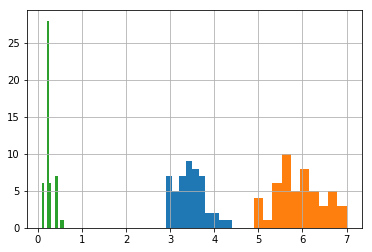

In [14]:
"""
Cleaning up data first.
"""
#iris_data = pd.read_csv_sync('iris-data.csv', na_values=['NA'])
iris_data = pd.read_csv('iris-data.csv', na_values=['NA'])
iris_data.loc[iris_data['class'] == 'versicolor', 'class'] = 'Iris-versicolor'
iris_data.loc[iris_data['class'] == 'Iris-setossa', 'class'] = 'Iris-setosa'

# This line drops any 'Iris-setosa' rows with a separal width less than 2.5 cm
iris_data = iris_data.loc[
    (iris_data['class'] != 'Iris-setosa') |
    (iris_data['sepal_width_cm'] >= 2.5)]
iris_data.loc[iris_data['class'] == 'Iris-setosa', 'sepal_width_cm'].hist()

iris_data.loc[(iris_data['class'] == 'Iris-versicolor') &
              (iris_data['sepal_length_cm'] < 1.0)]

iris_data.loc[(iris_data['class'] == 'Iris-versicolor') &
              (iris_data['sepal_length_cm'] < 1.0),
              'sepal_length_cm'] *= 100.0

iris_data.loc[iris_data['class'] ==
              'Iris-versicolor', 'sepal_length_cm'].hist()

iris_data.loc[(iris_data['sepal_length_cm'].isnull()) |
              (iris_data['sepal_width_cm'].isnull()) |
              (iris_data['petal_length_cm'].isnull()) |
              (iris_data['petal_width_cm'].isnull())]

iris_data.loc[iris_data['class'] == 'Iris-setosa', 'petal_width_cm'].hist()

average_petal_width = iris_data.loc[
    iris_data['class'] == 'Iris-setosa', 'petal_width_cm'].mean()

iris_data.loc[(iris_data['class'] == 'Iris-setosa') &
              (iris_data['petal_width_cm'].isnull()),
              'petal_width_cm'] = average_petal_width

iris_data.loc[(iris_data['class'] == 'Iris-setosa') &
              (iris_data['petal_width_cm'] == average_petal_width)]

iris_data.loc[(iris_data['sepal_length_cm'].isnull()) |
              (iris_data['sepal_width_cm'].isnull()) |
              (iris_data['petal_length_cm'].isnull()) |
              (iris_data['petal_width_cm'].isnull())]

In [4]:
"""
Save cleaned up data into a new csv file for subsequent use.
"""
iris_data.to_csv('iris-data-clean.csv', index=False)
#iris_data_clean = pd.read_csv_sync('iris-data-clean.csv')
iris_data_clean = pd.read_csv('iris-data-clean.csv')

In [5]:
"""
Perform classification
"""
# We can extract the data in this format from pandas like this:
all_inputs = iris_data_clean[['sepal_length_cm', 'sepal_width_cm',
                              'petal_length_cm', 'petal_width_cm']].values
syncer_obj.add_tag(all_inputs, "data to input into model")
#Syncing all features to modeldb
# Similarly, we can extract the classes
all_classes = iris_data_clean['class'].values

# Make sure that you don't mix up the order of the entries
# all_inputs[5] inputs should correspond to the class in all_classes[5]

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = cross_validation.train_test_split_sync(
    all_inputs, all_classes, train_size=0.75, random_state=1)

In [6]:
"""
Cross Validation
"""
# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()
syncer_obj.add_tag(decision_tree_classifier, "decision tree")

# Train the classifier on the training set
#decision_tree_classifier.fit_sync(training_inputs, training_classes)
decision_tree_classifier.fit(training_inputs, training_classes)

#How to identify fit data in modeldb ui
# Validate the classifier on the testing set using classification accuracy
# decision_tree_classifier.score(testing_inputs, testing_classes)

# NOTE: score is equivalent to sklearn.metrics.accuracy_score.
SyncableMetrics.compute_metrics(
    decision_tree_classifier, accuracy_score, testing_classes,
    decision_tree_classifier.predict(testing_inputs), training_inputs, "", "")

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_validation.cross_val_score_sync(
    decision_tree_classifier, all_inputs, all_classes, cv=10)

In [17]:
"""
Parameter-tuning
"""
@app.route("/demo/api",method=['GET','POST'])
def api():
    parameter_grid = {'criterion': ['gini', 'entropy'],
                      'splitter': ['best', 'random'],
                      'max_depth': [1, 2, 3, 4, 5],
                      'max_features': [1, 2, 3, 4]}

    cross_validation = StratifiedKFold(all_classes, n_folds=10)

    grid_search = GridSearchCV(decision_tree_classifier,
                               param_grid=parameter_grid,
                               cv=cross_validation)

    grid_search.fit_sync(all_inputs, all_classes)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    return(format(grid_search.best_score_))


NameError: name 'app' is not defined

In [15]:
# Get the best estimator
def get_estimator():
    decision_tree_classifier = grid_search.best_estimator_

    random_forest_classifier = RandomForestClassifier()

    parameter_grid = {'n_estimators': [5, 10, 25, 50],
                      'criterion': ['gini', 'entropy'],
                      'max_features': [1, 2, 3, 4],
                      'warm_start': [True, False]}

    cross_validation = StratifiedKFold(all_classes, n_folds=10)

    grid_search = GridSearchCV(random_forest_classifier,
                               param_grid=parameter_grid,
                               cv=cross_validation)

    grid_search.fit_sync(all_inputs, all_classes)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

In [16]:
random_forest_classifier = grid_search.best_estimator_
syncer_obj.sync()

NameError: name 'grid_search' is not defined